# Groupe 3
# Presentation Final

|Auteur|Centre|
|---|---|
|ACQUART Quentin|Aix-en-Provence|
|DIMEGLIO Nicolas|Aix-en-Provence|
|SIXDENIER Alexandre|Aix-en-Provence|
|VESSERON Alexandre|Aix-en-Provence|

## Import des différentes bibliothèques

In [91]:
import pathlib
import sklearn as sk
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from skimage.metrics import structural_similarity
from skimage.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio
from sklearn.metrics import confusion_matrix
import os
import collections
import random
import json
from PIL import Image

## Jeux de données

In [92]:
# L1
clean_dataset = "../Dataset soutenance"#"../Dataset/Project_Dataset_Clean"
light_dataset = "../Dataset/Project_Dataset_Test"
image_h = 180
image_w = 180
batch_s = 32

#L2
dataset_path_L2 = "../DatasetL2/Project_Dataset_Unzip/"
image_h_L2 = 320
image_w_L2 = 320
batch_s_L2 = 10

### Livrable 1
L'entreprise veut automatiser la sélection de photos pour l'annotation, le but est de fournir une méthode de classification binaire afin de filtrer les images qui ne sont pas des photos du dataset de départ. Pour ce faire nous allons nous appuyer sur l'architecture des réseaux de neurones, ainsi que l'analyse des résultats obtenus.
Toutes les parties doivent être détaillées dans le notebook :
    - les paramètre du réseau,
    - la fonction de perte ainsi que l'algorithme d'optimisation utilisé pour l’entraînement.

### Analyse à effectuer
- Graphique contenant l'évolution de l'erreur d’entraînement ainsi que de l'erreur de test
- Graphique d'évolution de l'accuracy pour ces deux datasets.

- L'analyse de ces résultats, notamment le compromis entre biais et variance (ou sur-apprentissage et sous-apprentissage).

- Une description des méthodes potentiellement utilisables pour améliorer les compromis biais/variance : technique de régularisation, drop-out, early-stopping, ...

In [93]:
data_dir = clean_dataset
data_dir = pathlib.Path(data_dir)

In [94]:
# Le train_set
prez_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=42,
  image_size=(image_h, image_w),
  batch_size=batch_s,
  color_mode='rgb',
  label_mode='int',
  labels="inferred"
)

Found 56 files belonging to 5 classes.


In [95]:
new_model = tf.keras.models.load_model('../Projet_Data_Science_G3/model/my_best_model.epoch19-loss0.59.hdf5')
score, accuracy = new_model.evaluate(prez_set, batch_size=batch_s)
print('Loss : ', score)
print('Global Accuracy : ', accuracy)

2/2 [==============================] - 0s 67ms/step - loss: 3.6726 - accuracy: 0.6786
Loss :  3.6726009845733643
Global Accuracy :  0.6785714030265808


2/2 [==============================] - 0s 111ms/step


C:\Users\nicos\PycharmProjects\DataScience\venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass display_labels=['Painting', 'Photo', 'Schematics', 'Sketch', 'Text'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


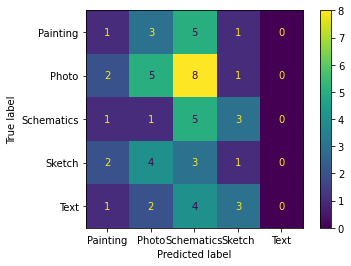

In [96]:
class_names =  prez_set.class_names

predictions = new_model.predict(prez_set,verbose=1)

list_labels = []
for image_batch, label_batch in prez_set:
    [list_labels.append(y.numpy()) for y in label_batch]

new_confus_mtx = sk.metrics.confusion_matrix(list_labels,predictions.argmax(axis=1))

disp = sk.metrics.ConfusionMatrixDisplay(new_confus_mtx,class_names)
disp.plot()

In [97]:
per_class_accuracies = {}
# Calculate the accuracy for each one of our classes
for idx, cls in enumerate(range(len(class_names))):
    true_negatives = np.sum(np.delete(np.delete(new_confus_mtx, idx, axis=0), idx, axis=1))
    true_positives = new_confus_mtx[idx, idx]
    per_class_accuracies[class_names[cls]] = (true_positives + true_negatives) / np.sum(new_confus_mtx)
print(per_class_accuracies)

{'Painting': 0.7321428571428571, 'Photo': 0.625, 'Schematics': 0.5535714285714286, 'Sketch': 0.6964285714285714, 'Text': 0.8214285714285714}


In [98]:
Photo_Painting_model = tf.keras.models.load_model('../Projet_Data_Science_G3/model/my_best_model_Photo_Painting.epoch24-loss0.34.hdf5')
Photo_Schementic_model = tf.keras.models.load_model('../Projet_Data_Science_G3/model/my_best_model_Photo_Schementic.epoch12-loss0.11.hdf5')
Photo_Sketch_model = tf.keras.models.load_model('../Projet_Data_Science_G3/model/my_best_model_Photo_Sketch.epoch12-loss0.00.hdf5')
Photo_Text_model = tf.keras.models.load_model('../Projet_Data_Science_G3/model/my_best_model_Photo_Text.epoch17-loss0.01.hdf5')
all_model = [Photo_Painting_model, Photo_Schementic_model, Photo_Sketch_model, Photo_Text_model]

import Classifier_Binary

def all_binary_classifier(train_set, test_set, batch_s, model):
    Classifier_Binary.autotune_Dataset(train_set, test_set)
    score, accuracy = model.evaluate(test_set, batch_size=batch_s)
    print('Loss : ', score)
    print('Global Accuracy : ', accuracy)
    return model.predict(test_set, verbose=1).argmax(axis=1)

def all_classifier(train_set, test_set, batch_s, all_model):
    predictions_list = []
    for model in all_model:
        predictions_list.append(all_binary_classifier(train_set, test_set, batch_s, model))
    return predictions_list

def pred_multi_binary_model(batch_size, dataset_binary):
    train_set, test_set = Classifier_Binary.dataset(dataset_binary, image_h=180, image_w=180,
                                                    batch_s=batch_size)
    pred = all_classifier(train_set, test_set, batch_size, all_model)
    print(pred)
    labels_pred = []
    for p1, p2, p3, p4 in zip(pred[0], pred[1], pred[2], pred[3]):
        res = p1 + p2 + p3 + p4
        proba = res / 4 if res != 0 else res
        labels_pred.append(1 if proba > 0.5 else 0)
    labels = []
    for image_batch, label_batch in test_set:
        [labels.append(y.numpy()) for y in label_batch]

    print(confusion_matrix(labels, labels_pred))

    new_confus_mtx = sk.metrics.confusion_matrix(labels,labels_pred)
    disp = sk.metrics.ConfusionMatrixDisplay(new_confus_mtx,display_labels=test_set.class_names)
    disp.plot()


Entrainement des classifieurs binaires et enregistrement des modèles entrainés.

Après avoir effectuer notre entrainement nous allons chargé les meilleurs modèles.
<br> Pour éditer les modèles veuillez changer les paramètres dans le fichier [Classifier_Binary.py](Classifier_Binary.py)
<br> Pour faire fonctionner la prédiction n'oubliez pas de générer l'architecture des dossiers dans le notebook [Préparation_des_données](Préparation_des_données.ipynb)
<br> On génère un dataset balanced, par la suite on va charger nos modèles, ensuite on fait la prédictions des modèles. On récupère les résultats des prédictions on fait la moyenne de ces prédictions et on affiche la matrice de confusion.

Found 56 files belonging to 2 classes.
Using 45 files for training.
Found 56 files belonging to 2 classes.
Using 11 files for validation.
['Photo', 'all_pictures']
1/1 [==============================] - 0s 69ms/step - loss: 2.6056 - accuracy: 0.2727
Loss :  2.605570077896118
Global Accuracy :  0.27272728085517883
1/1 [==============================] - 0s 66ms/step - loss: 1.1702 - accuracy: 0.7273
Loss :  1.1702208518981934
Global Accuracy :  0.7272727489471436
1/1 [==============================] - 0s 65ms/step - loss: 5.6771 - accuracy: 0.7273
Loss :  5.67708158493042
Global Accuracy :  0.7272727489471436
1/1 [==============================] - 0s 70ms/step - loss: 138.2507 - accuracy: 0.4545

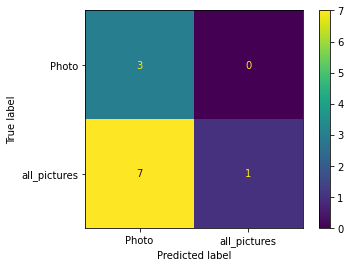

In [107]:
pred_multi_binary_model(batch_s,"../Dataset soutenance Binary/")

### Livrable 2

### Rappel du sujet
Le but est de traiter un ensemble de photographies afin de les rendre mieux traitables par les algorithmes de Machine Learning. Le traitement à réaliser est une opération de débruitage. Nous allons donc produire un notebook Jupyter explicitant ces étapes de prétraitement et leurs performances. Ces algorithmes s'appuieront sur les auto-encodeurs à convolution, et les appliqueront pour améliorer la qualité de l'image.
<br>Toutes les parties doivent être détaillées dans le notebook :

    - Le code de chargement du fichier.

    - Le code du débruitage sur un sous-ensemble d'images bruitées. Le code doit être accompagné d'explications.

    - Une étude de cas.

### Analyse à effectuer

Le but de cette étape va être le suivant :
    Traiter l'ensemble des photographies via un bruitage puis un débruitage à fin d'améliorer leur qualité.
    Le tout à l'aide d'un auto-encodeur à convolution.

In [100]:
def gaussian_noisy(img):
    img_resc = [pix*1./255 for pix in img]
    row,col,ch= img.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = img_resc + gauss
    noisy  = np.clip(noisy, 0., 1.)
    return noisy


normal_datagen = ImageDataGenerator(
        rescale=1./255,
        data_format="channels_last",
        validation_split=0.20
        )
noisy_datagen = ImageDataGenerator(
        preprocessing_function=gaussian_noisy,
        data_format="channels_last",
        validation_split=0.20
        )
train_generator = normal_datagen.flow_from_directory(
        dataset_path_L2,
        subset = 'training',
        target_size=(image_h_L2, image_w_L2),
        batch_size=batch_s_L2,
        shuffle=False,
        class_mode=None,
        )

train_noisy_generator = noisy_datagen.flow_from_directory(
        dataset_path_L2,
        subset = 'training',
        target_size=(image_h_L2, image_w_L2),
        batch_size=batch_s_L2,
        shuffle=False,
        class_mode=None,
        )

test_generator = normal_datagen.flow_from_directory(
        dataset_path_L2,
        subset = 'validation',
        target_size=(image_h_L2, image_w_L2),
        batch_size=batch_s_L2,
        shuffle=False,
        class_mode=None,
        )

test_noisy_generator = noisy_datagen.flow_from_directory(
        dataset_path_L2,
        subset = 'validation',
        target_size=(image_h_L2, image_w_L2),
        batch_size=batch_s_L2,
        shuffle=False,
        class_mode=None,
        )

Found 120 images belonging to 1 classes.
Found 120 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


## Mise en place des itérateurs

In [101]:
train_noisy= train_noisy_generator.next()
test_noisy= test_noisy_generator.next()
train = train_generator.next()
test = test_generator.next()
x_train = train
x_train_noisy = train_noisy
x_test = test
x_test_noisy = test_noisy

In [102]:
def display_single_image(img):
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off")

def display_image(X, n):
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(X[i].reshape(image_h_L2, image_w_L2,3))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [103]:
def ssim_score_compare(first_batch_pictures,second_batch_pictures):
    ssim_list_score = []
    for img_first_batch,img_second_batch in zip(first_batch_pictures,second_batch_pictures):
        (score, diff) = structural_similarity(img_first_batch, img_second_batch, multichannel=True, full=True)
        #diff = (diff * 255).astype("uint8")
        ssim_list_score.append(score)
    return ssim_list_score

def mse_score_compare(first_batch_pictures,second_batch_pictures):
    mse_list_score = []
    for img_first_batch,img_second_batch in zip(first_batch_pictures,second_batch_pictures):
        score = mean_squared_error(img_first_batch, img_second_batch)
        mse_list_score.append(score)
    return mse_list_score

def pksnr_score_compare(first_batch_pictures,second_batch_pictures):
    pksnr_list_score = []
    for img_first_batch,img_second_batch in zip(first_batch_pictures,second_batch_pictures):
        score = peak_signal_noise_ratio(img_first_batch, img_second_batch,data_range=1)
        pksnr_list_score.append(score)
    return pksnr_list_score

#### Chargement des meilleurs modèles.

In [104]:
mse_model = tf.keras.models.load_model('../Projet_Data_Science_G3/model/final_train_model.h5')
loss_minimum_model = tf.keras.models.load_model('../Projet_Data_Science_G3/model/L2_model.epoch294-loss0.0147.hdf5')
dssim_model = tf.keras.models.load_model('../Projet_Data_Science_G3/model/final_train_model_DSSIM.h5',compile=False)

full_mse_decoded_img = mse_model.predict(x_test_noisy, verbose=1)
loss_minimum_decoded_img = loss_minimum_model.predict(x_test_noisy, verbose=1)
dssim_decoded_img = dssim_model.predict(x_test_noisy, verbose=1)

1/1 [==============================] - 0s 84ms/step


Comparaison des modèles avec score `SSIM`

Image original
Image modèle mse
[0.05605998589962972, 0.062085610921875735, 0.06939829108096522, 0.06948725201432275, 0.07107478875632661, 0.05106991815978917, 0.06286170621572583, 0.050330477700177734, 0.07295439719243357, 0.052086363542704406]
Image modèle loss_minimum
[0.06322943218712813, 0.06124493361182969, 0.07021734268312706, 0.06671149668164915, 0.06863892073188511, 0.05041628068246621, 0.06356790651162171, 0.04824106668861181, 0.07133301956800632, 0.061572381807421604]
Image modèle dssim
[0.5902360243003981, 0.8076933623511722, 0.6268041201172173, 0.7285698688995815, 0.6644416767587761, 0.5804292919045158, 0.7028614542253374, 0.7310554743605565, 0.7462835525326755, 0.7119570712059305]


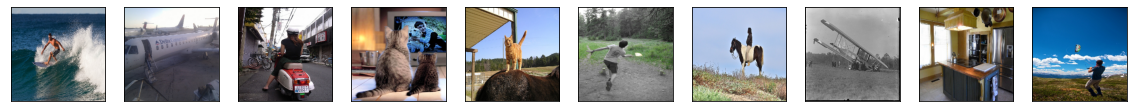

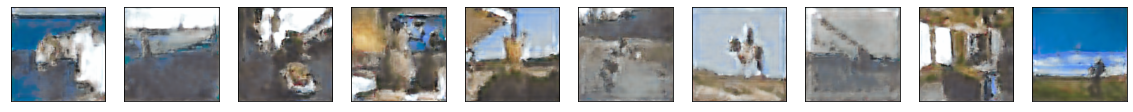

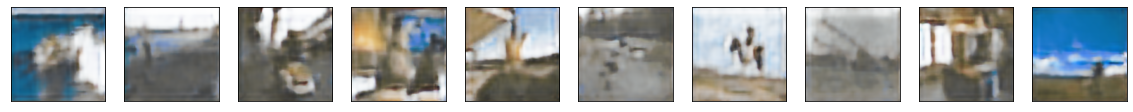

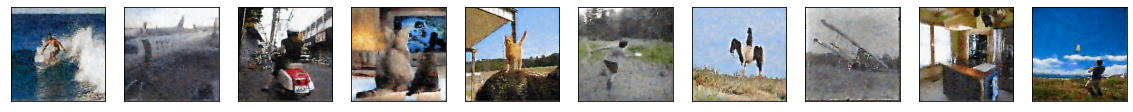

In [105]:
print("Image original")
display_image(x_test,10)
print("Image modèle mse")
print(ssim_score_compare(x_test_noisy,full_mse_decoded_img))
display_image(full_mse_decoded_img,10)
print("Image modèle loss_minimum")
print(ssim_score_compare(x_test_noisy,loss_minimum_decoded_img))
display_image(loss_minimum_decoded_img,10)
print("Image modèle dssim")
print(ssim_score_compare(x_test,dssim_decoded_img))
display_image(dssim_decoded_img,10)

### Livrable 3
### Rappel du sujet
Le but est de créer un réseau de neurones qui génère des légendes pour des images en s'appuyant sur le dataset MS COCO.
Le réseau sera composé de deux parties :
 - la partie CNN qui encode les images en une représentation interne,
 - et la partie RNN utilise cette représentation pour prédire l'annotation séquence par séquence.

Avant l'entraînement du modèle les images sont prétraitées par un CNN pré-entrainé pour la classification.

Le livrable contient :
- Un descriptif sur le pré-traitements d'images et du texte.
- L'architecture complète du réseau utilisé pour le captioning explicitant le type de CNN utilisé pour les prétraitements.
- Une analyse sous forme de courbes des performances du réseau pendant l'entrainement.
- Quelques exemples pour les tests.

### Analyse à effectuer

Le but de cette étape va être le suivant :
- Prétraiter les données
- Classifier les données par un CNN
- Prédire les annotations via un RNN

Afin d'obtenir notre réseau de neurones qui génère des légendes pour des photographies. Nous allons combiner le CNN et le RNN.
Le RNN est branché sur l'avant-dernière couche de notre CNN afin de récupérer le traitement préalablement fait pour effectuer la prédiction d'annotation.